# qPCR timecourse

In [374]:
import pandas as pd
import plotnine as pn

from scipy.stats import sem
import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import f_oneway
from scipy.stats import kruskal

Functions

In [375]:
phages=["bop","car","ccs1","ccs2","ccs3","ump","carl","bill","ben","sds1","sds2","pg2","pg9","pg11","pg13","v12"]
phage_to_upper = {"bop":"Bop",
                 "car":"Car",
                 "ccs1":"CCS1",
                 "ccs2":"CCS2",
                 "ccs3":"CCS3",
                 "ump":"Ump",
                 "carl":"Carl",
                 "bill":"Bill",
                 "ben":"Ben",
                 "sds1":"SDS1",
                 "sds2":"SDS2",
                 "pg2":"PG2",
                 "pg9":"PG9",
                 "pg11":"PG11",
                 "pg13":"PG13",
                 "v12":"V12"}
phage_order = ["V12","Bop","Ben","Bill","Car","Carl","CCS1","SDS1","SDS2","CCS2","CCS3","PG2","PG9","PG11","PG13","Ump"]

def parse_phages(text):
    '''
    Takes in a text string with phages in it and returns a list of the phages
    '''
    text_lower = str.lower(text)
    phage_list = []
    #Deal with car and carl
    if "carl" in text_lower:
        phage_list.append("carl")
        text_lower = text_lower.replace("carl","")
    for phage in phages:
        if phage in text_lower:
            phage_list.append(phage)
    phage_list = [phage_to_upper[x] for x in phage_list]
    return(phage_list)

def mean(x):
    return(sum(x)/len(x))

Import qpcr data

In [376]:
#Import data
file = "data/qpcr_timepoint.txt"
raw_dat = pd.read_table(file)

#Format data
##Parse phages
raw_dat["Phage"] = raw_dat.cocktail.apply(func=parse_phages)
##Count phages
raw_dat["num_phages"] = raw_dat.Phage.apply(func=lambda x: len(x))
##Format time
raw_dat["timepoint"] = [int(x.strip("h")) for x in raw_dat.timepoint]
raw_dat = raw_dat.melt(id_vars = ['host','cocktail','condition','phage_measured','timepoint','Phage','num_phages'], 
                       value_vars = ["value1","value2","value3"],
                      var_name = "replicate")
raw_dat["cocktail_name"] = ["Cocktail " + str(x.split()[-2]) for x in raw_dat.cocktail]

raw_dat.head(4)

,host,cocktail,condition,phage_measured,timepoint,Phage,num_phages,replicate,value,cocktail_name
0,YI6,Yi6-1_Cocktail 1 (Carl+Ben+CCS2),with host,CCS2,0,"[Carl, CCS2, Ben]",3,value1,8.262565,Cocktail 1
1,YI6,Yi6-1_Cocktail 1 (Carl+Ben+CCS2),with host,CCS2,24,"[Carl, CCS2, Ben]",3,value1,9.104303,Cocktail 1
2,YI6,Yi6-1_Cocktail 1 (Carl+Ben+CCS2),with host,CCS2,48,"[Carl, CCS2, Ben]",3,value1,9.493282,Cocktail 1
3,YI6,Yi6-1_Cocktail 1 (Carl+Ben+CCS2),with host,CCS2,72,"[Carl, CCS2, Ben]",3,value1,9.355837,Cocktail 1


Format qpcr data

In [377]:
mean_nohost_df = raw_dat.query('condition=="no host"')\
                            .groupby(["cocktail_name","timepoint","phage_measured"])\
                            .agg({'value':[mean,sem ]})\
                            .reset_index()
mean_nohost_df.columns = ["cocktail_name", "timepoint","phage_measured","val","err"]


def subtraction_func(row):
    cocktail=row.cocktail_name
    phage = row["phage_measured"]
    timepoint = row.timepoint
    mean_nohost_val = float(mean_nohost_df.query('phage_measured == @phage & cocktail_name == @cocktail & timepoint == @timepoint').val)
    return(mean_nohost_val)



with_host_minus_nohost = raw_dat.query('condition=="with host"').copy()
with_host_minus_nohost["nohost_mean"] = with_host_minus_nohost.apply(axis=1, func=subtraction_func)
with_host_minus_nohost["value_minus_nohost"] = with_host_minus_nohost.apply(axis=1, func= lambda row: row.value - row.nohost_mean)

def format_cocktail_title(row):
    out = ''
    out +=  ' , '.join(row.Phage)
    return(out)

with_host_minus_nohost["formatted_cocktail_name"] = with_host_minus_nohost.apply(axis=1, func=format_cocktail_title)

phage_type_dict = {"Bop":"M",
                 "Car":"M",
                 "CCS1":"M",
                 "CCS2":"S",
                 "CCS3":"S",
                 "Ump":"P",
                 "Carl":"M",
                 "Bill":"M",
                 "Ben":"M",
                 "SDS1":"S",
                 "SDS2":"S",
                 "PG2":"S",
                 "PG9":"S",
                 "PG11":"S",
                 "PG13":"S",
                 "V12":"M"}
phage_order = ["V12","Bop","Ben","Bill","Car","Carl","CCS1","SDS1","SDS2","CCS2","CCS3","PG2","PG9","PG11","PG13","Ump"]
phage_subtype = {x:"{}({})".format(x,phage_type_dict[x]) for x in phage_order}


qpcr_plot_dat = with_host_minus_nohost.copy()
#Mean and err
qpcr_plot_dat = qpcr_plot_dat.groupby(["cocktail_name","timepoint","phage_measured"])\
    .agg({'value_minus_nohost':[mean,np.std ],
         "formatted_cocktail_name":"first"})\
    .reset_index()
qpcr_plot_dat.columns = ["Cocktail","timepoint","phage_measured","value","err","formatted_cocktail_name"]
qpcr_plot_dat["errp"] = qpcr_plot_dat.apply(axis=1, func = lambda row: row.value + row.err)
qpcr_plot_dat["errn"] = qpcr_plot_dat.apply(axis=1, func = lambda row: row.value - row.err)
qpcr_plot_dat["phage_measured"] = [phage_subtype[x] for x in qpcr_plot_dat.phage_measured]
qpcr_plot_dat["phage_measured"] = pd.Categorical(qpcr_plot_dat["phage_measured"],
                                            categories=["Ben(M)","Bill(M)","Carl(M)","CCS1(M)", "CCS2(S)","SDS1(S)","Ump(P)"])


Import OD

In [175]:
#Import OD values
od_sheets = pd.read_excel('data/Pride_qpcr/OD_formatted.xlsx', sheet_name=None)
od_file = pd.concat([v for k,v in od_sheets.items()])


#Subtract blank
blank_val = mean(od_file.negative1.append(od_file.negative2).append(od_file.negative3))
for col in ['value1', 'value2','value3','phage_only1','phage_only2','phage_only3','host_only1','host_only2','host_only3']:
    od_file[col] = od_file[col] - blank_val

#Format data
def get_avg(row):
    #Get values
    values = [row.value1, row.value2, row.value3]
    phage_values = [row.phage_only1, row.phage_only2, row.phage_only3]
    host_values = [row.host_only1, row.host_only2, row.host_only3]
    #Get averages
    row["value_avg"] = mean(values)
    row["phage_avg"] = mean(phage_values)
    row["host_avg"] = mean(host_values)
    #Get SDs
    row["value_sd"] = np.std(values)
    row["phage_sd"] = np.std(phage_values)
    row["host_sd"] = np.std(host_values)
    #SEMs
    row["value_sem"] = sem(values)
    row["phage_sem"] = sem(phage_values)
    row["host_sem"] = sem(host_values)
    return(row)
od_file = od_file.apply(axis=1, func=get_avg)

od_file = od_file.reset_index()
od_file["Hour"] = [round(x,4) for x in od_file.Hour]


excludes = [23.9167, 24.0000, 24.0833,24.1667, 24.2500,24.3333,
            47.9167, 48.0000, 48.0833, 48.1667, 48.2500, 48.3333, 48.4167, 48.5000, 48.5833]
od_plot_dat = od_file.query('Hour not in @excludes').copy()

od_plot_dat["cocktail_long"] = od_plot_dat["Cocktail"]
od_plot_dat["Cocktail"] = ["Cocktail " + str(x.split()[1][0]) for x in od_plot_dat.cocktail_long]

Calculate stats

In [436]:
out_list = []
for cocktail in cocktail_list:
    for hour in [0,24,48,72]:
        value_list = []
        dat_ss = with_host_minus_nohost.query('cocktail_name == @cocktail & timepoint==@hour')
        phages = set(dat_ss.phage_measured)
        for phage in phages:
            value_list.append( dat_ss.query('phage_measured== @phage').value_minus_nohost.values )
        anova = kruskal(*value_list)
        out_list.append([cocktail, hour, anova.statistic, anova.pvalue])

anova_df = pd.DataFrame(out_list, columns=["Cocktail","Hour","stat","pvalue"])
anova_df["sig"] = [x<0.05 for x in anova_df.pvalue]
anova_df_sig = anova_df.query('sig==True')
anova_df.head(4)

,Cocktail,Hour,stat,pvalue,sig
0,Cocktail 1,0,0.622222,0.732632,False
1,Cocktail 1,24,3.822222,0.147916,False
2,Cocktail 1,48,5.600000,0.060810,False
3,Cocktail 1,72,5.600000,0.060810,False


## Plot

Plot "phage only" wells over time to ensure nothing weird is happening

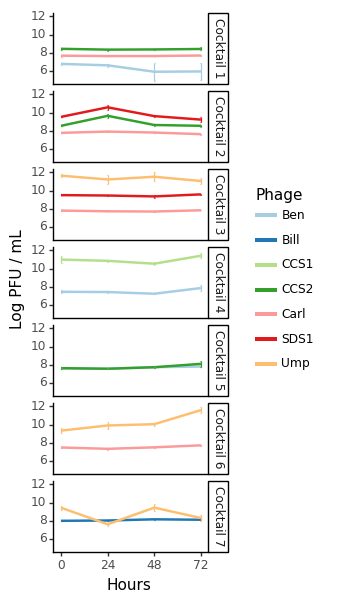

<ggplot: (8747657753986)>

In [125]:
plot_dat = raw_dat.query('condition=="no host"').copy()
plot_dat = plot_dat.groupby(["cocktail_name","timepoint","phage_measured"])\
    .agg({'value':[mean,sem ]})\
    .reset_index()
plot_dat.columns = ["Cocktail","timepoint","phage_measured","value","err"]
plot_dat["errp"] = plot_dat.apply(axis=1, func = lambda row: row.value + row.err)
plot_dat["errn"] = plot_dat.apply(axis=1, func = lambda row: row.value - row.err)

colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']

pn.options.figure_size = (2,7)

p = ( pn.ggplot( data = plot_dat) +
    pn.geom_line( pn.aes(x= "timepoint", y="value", color="phage_measured" ), size=1) +
     pn.geom_errorbar( pn.aes(x = "timepoint",  ymin = "errn", ymax = "errp", color="phage_measured")) +
     pn.scale_x_continuous(breaks = [0,24,48,72]) +
     pn.scale_color_manual(colors) +
     pn.labs(x="Hours", y="Log PFU / mL", color="Phage") +
     pn.facet_grid("Cocktail~.") +
     pn.theme_classic()
    
    )
p

Plot Rough qpcr

/mnt/c/anaconda3/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


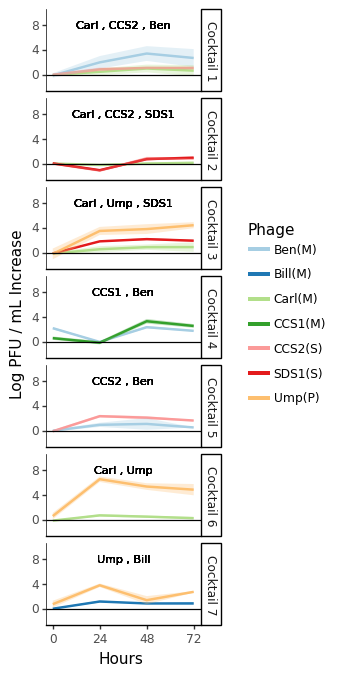

<ggplot: (8747662913046)>

In [230]:
qpcr_plot_dat = with_host_minus_nohost.copy()
#Mean and err
qpcr_plot_dat = qpcr_plot_dat.groupby(["cocktail_name","timepoint","phage_measured"])\
    .agg({'value_minus_nohost':[mean,np.std ],
         "formatted_cocktail_name":"first"})\
    .reset_index()
qpcr_plot_dat.columns = ["Cocktail","timepoint","phage_measured","value","err","formatted_cocktail_name"]
qpcr_plot_dat["errp"] = qpcr_plot_dat.apply(axis=1, func = lambda row: row.value + row.err)
qpcr_plot_dat["errn"] = qpcr_plot_dat.apply(axis=1, func = lambda row: row.value - row.err)
qpcr_plot_dat["phage_measured"] = [phage_subtype[x] for x in qpcr_plot_dat.phage_measured]
qpcr_plot_dat["phage_measured"] = pd.Categorical(qpcr_plot_dat["phage_measured"],
                                            categories=["Ben(M)","Bill(M)","Carl(M)","CCS1(M)", "CCS2(S)","SDS1(S)","Ump(P)"])


pn.options.figure_size = (2,8)
p = ( pn.ggplot(data = qpcr_plot_dat) +
    pn.geom_line( pn.aes(x= "timepoint", y="value", color="phage_measured" ), size=1) +
     pn.geom_ribbon( pn.aes(x = "timepoint",  ymin = "errn", ymax = "errp", fill="phage_measured"), alpha=.3, color=None) +
     pn.geom_text( pn.aes(label="formatted_cocktail_name", x=36, y=8), size=8) +
     pn.geom_hline(pn.aes(yintercept=0)) +
     pn.scale_x_continuous(breaks = [0,24,48,72]) +
     pn.scale_y_continuous(limits = [-2,10], breaks=[0,4,8]) +
     pn.scale_color_manual(colors) +
     pn.scale_fill_manual(colors) +
     pn.labs(x="Hours", y="Log PFU / mL Increase", color="Phage", title="") +
     pn.guides(fill=None) +
     pn.facet_grid("Cocktail~", scales="free") +
     pn.theme_classic() +
     pn.theme(
         axis_line_y = pn.element_line(color="black", size = 0.5),
         panel_border= pn.element_blank())
    )

p

Plot rough OD

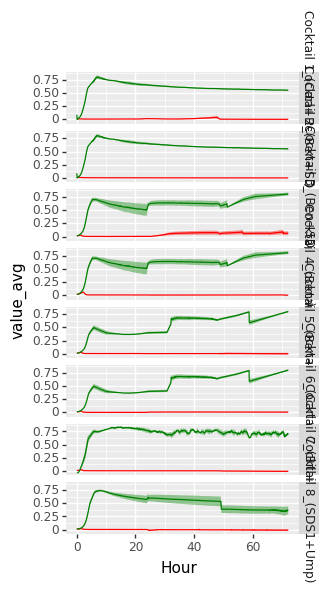

<ggplot: (8755339406538)>

In [154]:
pn.options.figure_size = (3, 6)

plot_dat = od_file.copy()
plot_dat = plot_dat.query('Hour not in @excludes')

p = (pn.ggplot( data = plot_dat) +
     pn.geom_line( pn.aes( x= "Hour", y="value_avg"), color="red") +
     pn.geom_line( pn.aes( x= "Hour", y="host_avg"), color="green") +
     pn.geom_ribbon( pn.aes( x= "Hour", ymin="host_avg-host_sem", ymax="host_avg+host_sem"), fill="green", color=None, alpha=.4) +
    pn.geom_ribbon( pn.aes( x= "Hour", ymin="value_avg-value_sem", ymax="value_avg+value_sem"), fill="red", color=None, alpha=.4) +

     pn.facet_grid('Cocktail~.')
    )
p

# Final Figure

With stats

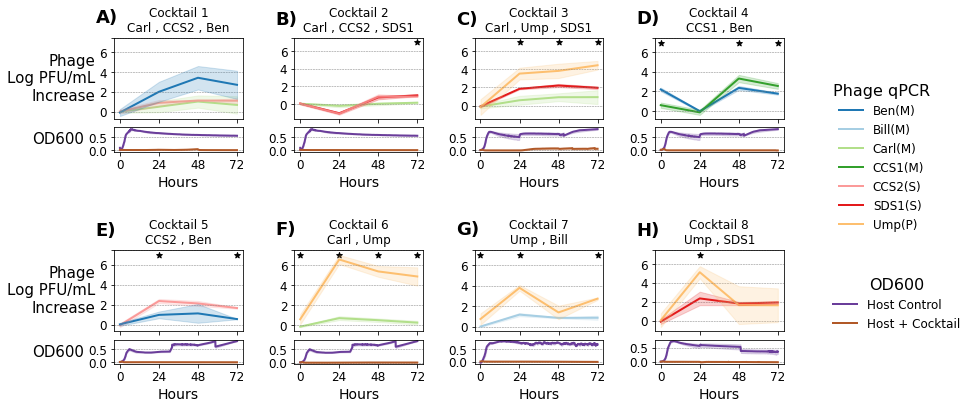

In [440]:
RIBBON_ALPHA=0.2
SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS = 1

phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}
od_color_dict={"Host Control":"#6a3d9a",
              "Host + Cocktail":"#b15928"}

fig,axs =  plt.subplots(5,4,
                        figsize=(12,6),
                       gridspec_kw={'height_ratios': [1, .3,SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS, 1, .3]})

fig.subplots_adjust(wspace=.4, hspace=.15)
for j in [0,1,2,3]:
    axs[2,j].set_visible(False)

cocktail_list = ["Cocktail " + str(j) for j in range(1,9)]

for i, cocktail in enumerate(cocktail_list):
    j=0
    if i > 3:
        i-=4
        j+=3
    #Subset data
    od_dat_ss = od_plot_dat.query('Cocktail == @cocktail')
    qpcr_dat_ss = qpcr_plot_dat.query('Cocktail == @cocktail')
    
    #Get x values
    od_x = od_dat_ss.Hour.values
    
    #Get y values for qpcr
    phage_y_values = {}
    phage_y_errp = {}
    phage_y_errn = {}
    phage_x = {}
    for phage in set(qpcr_dat_ss.phage_measured):
        #Subset data
        phage_ss = qpcr_dat_ss.query('phage_measured == @phage')
        #Get x values
        phage_x[phage] = phage_ss.timepoint.values
        #Get y values
        phage_y_values[phage] = phage_ss.value.values
        #Get y error
        phage_y_errp[phage] = phage_ss.errp.values
        phage_y_errn[phage] = phage_ss.errn.values
        #Get colors
        color_ = phage_color_dict[phage]
        
        #Plot error
        axs[j,i].fill_between(phage_x[phage], phage_y_errn[phage], phage_y_errp[phage], 
                              color= color_, alpha=RIBBON_ALPHA, zorder=2)
        
        #Plot line
        axs[j,i].plot(phage_x[phage],phage_y_values[phage], 
                      color=color_, zorder=1, linewidth=2)
        
        
    
    #Get y values for OD
    od_control_y = od_dat_ss.host_avg.values
    od_cocktail_y = od_dat_ss.value_avg.values
    #Get errors for OD
    od_control_y_sem = od_dat_ss.host_sem.values
    od_cocktail_y_sem = od_dat_ss.value_sem.values
    
    #Plot OD line
    axs[j+1,i].plot(od_x, od_control_y,  color=od_color_dict["Host Control"], linewidth=2)
    axs[j+1,i].plot(od_x, od_cocktail_y, color=od_color_dict["Host + Cocktail"], linewidth=2)
    
    #Plor OD error
    axs[j+1,i].fill_between(od_x, od_control_y - od_control_y_sem, od_control_y + od_control_y_sem, 
                            color=od_color_dict["Host Control"], alpha=RIBBON_ALPHA)
    axs[j+1,i].fill_between(od_x, od_cocktail_y - od_cocktail_y_sem, od_cocktail_y + od_cocktail_y_sem,
                            color=od_color_dict["Host + Cocktail"], alpha=RIBBON_ALPHA)
    
    #Qpcr title
    title_text = qpcr_dat_ss.Cocktail.values[0] + "\n" +  qpcr_dat_ss.formatted_cocktail_name.values[0]        
    axs[j,i].set_title(title_text)
    #axis grid
    axs[j,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    axs[j+1,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    
    #Add stats
    stat_df = anova_df_sig.query('Cocktail==@cocktail')
    if stat_df.shape[0] != 0:
        axs[j,i].scatter(stat_df.Hour, [7] * stat_df.shape[0] , marker="*", color="black")
    
#Adjust qpcr plot
for j in [0,3]:
    for i in [0,1,2,3]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].set_yticks( [0,2,4,6,7.5] )
        axs[j,i].set_yticklabels( [0,2,4,6] )
        axs[j,i].set_xticklabels( [] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        if i==0:
            axs[j,i].set_ylabel('Phage\nLog PFU/mL\nIncrease', size=15, rotation=0,
                                verticalalignment="center",horizontalalignment="right" )


#Adjust OD plot
for j in [1,4]:
    for i in [0,1,2,3]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        #Set x axis labels
        axs[j,i].set_xlabel('Hours', size=14)
        if i==0:
            axs[j,i].set_ylabel('OD600', size=15, rotation=0,
                                verticalalignment="center", horizontalalignment="right")
            
#Phage legend
legend_lines = [plt.Line2D([0],[0], color=c, lw=2) for c in phage_color_dict.values()]
legend_labels = [x for x in phage_color_dict.keys()]
phage_legend = plt.legend(legend_lines, legend_labels,
                  bbox_to_anchor=(1.3, 12), loc='upper left', 
                          prop={'size': 12}, title="Phage qPCR", frameon=False)
plt.setp(phage_legend.get_title(),fontsize=16)

#OD Legend
legend_lines2 = [plt.Line2D([0],[0], color=c, lw=2) for c in od_color_dict.values()]
legend_labels2 = [x for x in od_color_dict.keys()]
OD_legend = plt.legend(legend_lines2, legend_labels2,
                  bbox_to_anchor=(1.3, 4), loc='upper left', 
                          prop={'size': 12}, title="OD600", frameon=False)
plt.setp(OD_legend.get_title(),fontsize=16)
#Add back phage legend
plt.gca().add_artist(phage_legend)

alphabet = ["A)","B)","C)","D)","E)","F)","G)","H)"]
alphabet_positions = [(0,0),(0,1),(0,2),(0,3), (3,0),(3,1),(3,2),(3,3)]
for i in range(0,8):  
    axs[alphabet_positions[i]].text(x=-15, y=9, s=alphabet[i],size=18, fontweight="bold")
    
plt.savefig("figures/Qpcr_timecourse_fig_stats.png", bbox_inches='tight')

Without stats

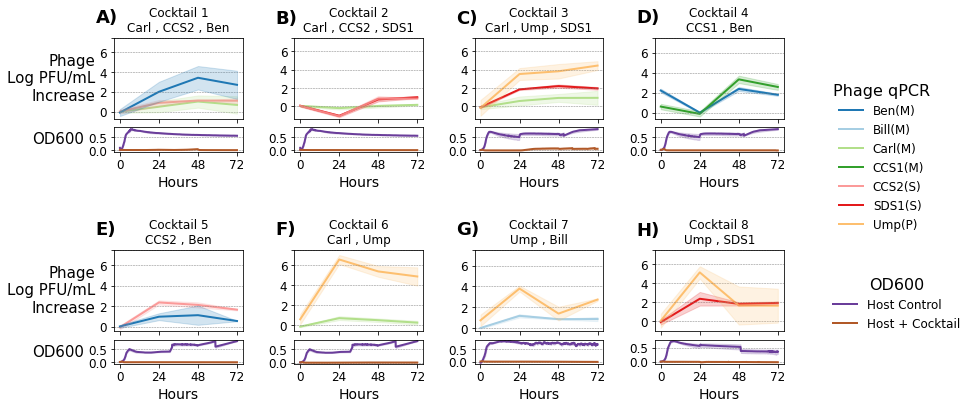

In [439]:
RIBBON_ALPHA=0.2
SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS = 1

phage_color_dict= {"Ben(M)":'#1f78b4',
                  "Bill(M)":'#a6cee3',
                  "Carl(M)":'#b2df8a',
                  "CCS1(M)":'#33a02c',
                  "CCS2(S)":'#fb9a99',
                  "SDS1(S)":'#e31a1c',
                  "Ump(P)":'#fdbf6f'}
od_color_dict={"Host Control":"#6a3d9a",
              "Host + Cocktail":"#b15928"}

fig,axs =  plt.subplots(5,4,
                        figsize=(12,6),
                       gridspec_kw={'height_ratios': [1, .3,SPACE_BETWEEN_TOP_AND_BOTTOM_ROWS, 1, .3]})

fig.subplots_adjust(wspace=.4, hspace=.15)
for j in [0,1,2,3]:
    axs[2,j].set_visible(False)

cocktail_list = ["Cocktail " + str(j) for j in range(1,9)]

for i, cocktail in enumerate(cocktail_list):
    j=0
    if i > 3:
        i-=4
        j+=3
    #Subset data
    od_dat_ss = od_plot_dat.query('Cocktail == @cocktail')
    qpcr_dat_ss = qpcr_plot_dat.query('Cocktail == @cocktail')
    
    #Get x values
    od_x = od_dat_ss.Hour.values
    
    #Get y values for qpcr
    phage_y_values = {}
    phage_y_errp = {}
    phage_y_errn = {}
    phage_x = {}
    for phage in set(qpcr_dat_ss.phage_measured):
        #Subset data
        phage_ss = qpcr_dat_ss.query('phage_measured == @phage')
        #Get x values
        phage_x[phage] = phage_ss.timepoint.values
        #Get y values
        phage_y_values[phage] = phage_ss.value.values
        #Get y error
        phage_y_errp[phage] = phage_ss.errp.values
        phage_y_errn[phage] = phage_ss.errn.values
        #Get colors
        color_ = phage_color_dict[phage]
        
        #Plot error
        axs[j,i].fill_between(phage_x[phage], phage_y_errn[phage], phage_y_errp[phage], 
                              color= color_, alpha=RIBBON_ALPHA, zorder=2)
        
        #Plot line
        axs[j,i].plot(phage_x[phage],phage_y_values[phage], 
                      color=color_, zorder=1, linewidth=2)
        
        
    
    #Get y values for OD
    od_control_y = od_dat_ss.host_avg.values
    od_cocktail_y = od_dat_ss.value_avg.values
    #Get errors for OD
    od_control_y_sem = od_dat_ss.host_sem.values
    od_cocktail_y_sem = od_dat_ss.value_sem.values
    
    #Plot OD line
    axs[j+1,i].plot(od_x, od_control_y,  color=od_color_dict["Host Control"], linewidth=2)
    axs[j+1,i].plot(od_x, od_cocktail_y, color=od_color_dict["Host + Cocktail"], linewidth=2)
    
    #Plor OD error
    axs[j+1,i].fill_between(od_x, od_control_y - od_control_y_sem, od_control_y + od_control_y_sem, 
                            color=od_color_dict["Host Control"], alpha=RIBBON_ALPHA)
    axs[j+1,i].fill_between(od_x, od_cocktail_y - od_cocktail_y_sem, od_cocktail_y + od_cocktail_y_sem,
                            color=od_color_dict["Host + Cocktail"], alpha=RIBBON_ALPHA)
    
    #Qpcr title
    title_text = qpcr_dat_ss.Cocktail.values[0] + "\n" +  qpcr_dat_ss.formatted_cocktail_name.values[0]        
    axs[j,i].set_title(title_text)
    #axis grid
    axs[j,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    axs[j+1,i].grid(which='major', axis="y", linestyle='--', linewidth='0.5', color='grey')
    
    
#Adjust qpcr plot
for j in [0,3]:
    for i in [0,1,2,3]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].set_yticks( [0,2,4,6,7.5] )
        axs[j,i].set_yticklabels( [0,2,4,6] )
        axs[j,i].set_xticklabels( [] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        if i==0:
            axs[j,i].set_ylabel('Phage\nLog PFU/mL\nIncrease', size=15, rotation=0,
                                verticalalignment="center",horizontalalignment="right" )


#Adjust OD plot
for j in [1,4]:
    for i in [0,1,2,3]:
        axs[j,i].set_xticks( [0,24,48,72] )
        axs[j,i].tick_params(axis = 'both', which = 'major', labelsize = 12)
        #Set x axis labels
        axs[j,i].set_xlabel('Hours', size=14)
        if i==0:
            axs[j,i].set_ylabel('OD600', size=15, rotation=0,
                                verticalalignment="center", horizontalalignment="right")

#Phage legend
legend_lines = [plt.Line2D([0],[0], color=c, lw=2) for c in phage_color_dict.values()]
legend_labels = [x for x in phage_color_dict.keys()]
phage_legend = plt.legend(legend_lines, legend_labels,
                  bbox_to_anchor=(1.3, 12), loc='upper left', 
                          prop={'size': 12}, title="Phage qPCR", frameon=False)
plt.setp(phage_legend.get_title(),fontsize=16)

#OD Legend
legend_lines2 = [plt.Line2D([0],[0], color=c, lw=2) for c in od_color_dict.values()]
legend_labels2 = [x for x in od_color_dict.keys()]
OD_legend = plt.legend(legend_lines2, legend_labels2,
                  bbox_to_anchor=(1.3, 4), loc='upper left', 
                          prop={'size': 12}, title="OD600", frameon=False)
plt.setp(OD_legend.get_title(),fontsize=16)
#Add back phage legend
plt.gca().add_artist(phage_legend)

alphabet = ["A)","B)","C)","D)","E)","F)","G)","H)"]
alphabet_positions = [(0,0),(0,1),(0,2),(0,3), (3,0),(3,1),(3,2),(3,3)]
for i in range(0,8):  
    axs[alphabet_positions[i]].text(x=-15, y=9, s=alphabet[i],size=18, fontweight="bold")
    
plt.savefig("figures/Qpcr_timecourse_fig_nostats.png", bbox_inches='tight')